# kanecounty Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 51 # kanecounty

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              818 non-null    int64  
 1   dimCustomerMasterId       818 non-null    int64  
 2   customerNumber            818 non-null    object 
 3   year                      818 non-null    object 
 4   productGrouping           818 non-null    object 
 5   totalSpent                818 non-null    float64
 6   recentDate                818 non-null    object 
 7   attendancePercent         818 non-null    float64
 8   renewedBeforeDays         818 non-null    int64  
 9   isBuyer                   818 non-null    object 
 10  source_tenure             818 non-null    int64  
 11  tenure                    818 non-null    int64  
 12  distToVenue               818 non-null    float64
 13  totalGames                818 non-null    int64  
 14  recency   

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          818 non-null    int64  
 1   dimCustomerMasterId   818 non-null    int64  
 2   customerNumber        818 non-null    object 
 3   year                  818 non-null    object 
 4   productGrouping       818 non-null    object 
 5   totalSpent            818 non-null    float64
 6   recentDate            818 non-null    object 
 7   attendancePercent     818 non-null    float64
 8   renewedBeforeDays     818 non-null    int64  
 9   isBuyer               818 non-null    object 
 10  source_tenure         818 non-null    int64  
 11  tenure                818 non-null    int64  
 12  distToVenue           818 non-null    float64
 13  totalGames            818 non-null    int64  
 14  recency               818 non-null    int64  
 15  missed_games_1        8

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (736, 47)
Unseen Data For Predictions: (82, 47)
Data for Modeling (A Class): (736, 47)
Unseen Data For Predictions: (82, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(818, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  818 non-null    int64  
 1   totalSpent           818 non-null    float64
 2   renewedBeforeDays    818 non-null    int64  
 3   source_tenure        818 non-null    int64  
 4   tenure               818 non-null    int64  
 5   distToVenue          818 non-null    float64
 6   totalGames           818 non-null    int64  
 7   missed_games_1       818 non-null    int64  
 8   missed_games_2       818 non-null    int64  
 9   missed_games_over_2  818 non-null    int64  
 10  isNextYear_Buyer     818 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 70.4 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,renewedBeforeDays,source_tenure,tenure,distToVenue,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,-0.05,-0.05,0.31,0.31,-0.11,0.11,0.06,0.06,-0.04,0.12
totalSpent,-0.05,1.00,-0.13,-0.06,-0.06,-0.05,0.57,0.20,0.28,0.77,0.16
renewedBeforeDays,-0.05,-0.13,1.00,-0.17,-0.17,-0.04,-0.14,-0.08,-0.07,-0.14,0.38
source_tenure,0.31,-0.06,-0.17,1.00,1.00,-0.06,0.01,0.01,0.01,-0.07,-0.41
tenure,0.31,-0.06,-0.17,1.00,1.00,-0.06,0.01,0.01,0.01,-0.07,-0.41
distToVenue,-0.11,-0.05,-0.04,-0.06,-0.06,1.00,-0.01,0.03,-0.01,-0.06,-0.06
totalGames,0.11,0.57,-0.14,0.01,0.01,-0.01,1.00,0.66,0.55,0.55,0.22
missed_games_1,0.06,0.20,-0.08,0.01,0.01,0.03,0.66,1.00,0.53,0.22,0.15
missed_games_2,0.06,0.28,-0.07,0.01,0.01,-0.01,0.55,0.53,1.00,0.36,0.17
missed_games_over_2,-0.04,0.77,-0.14,-0.07,-0.07,-0.06,0.55,0.22,0.36,1.00,0.15


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (654, 11)
Unseen Data For Predictions: (164, 11)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "totalSpent",
        "renewedBeforeDays",
        "source_tenure",
        "distToVenue",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,8422
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(654, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(True,
 0      0
 1      1
 2      0
 3      1
 4      0
       ..
 649    0
 650    1
 651    1
 652    1
 653    1
 Name: isNextYear_Buyer, Length: 654, dtype: int64,
 False,
 False,
 -1,
 384    0
 361    1
 178    1
 242    0
 485    1
       ..
 222    1
 404    1
 123    1
 20     0
 271    0
 Name: isNextYear_Buyer, Length: 523, dtype: int64,
 <MLUsecase.CLASSIFICATION: 1>,
 [],
 'box-cox',
 {'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x7f824bab4250>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x7f824bab4290>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x7f82474bee10>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x7f824bab43d0>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x7f824bab44d0>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x7f824bab4610>,
  'mcc': <pycaret.contain

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.8202,0.8875,0.8383,0.8049,0.8192,0.6405,0.6445,0.0200
8,NGBClassifier,0.8127,0.8820,0.8780,0.7720,0.8203,0.6264,0.6346,0.3330
2,Gradient Boosting Classifier,0.8126,0.8886,0.8585,0.7823,0.8175,0.6261,0.6309,0.0330
3,Extra Trees Classifier,0.8107,0.8842,0.8512,0.7815,0.8136,0.6220,0.6267,0.1730
7,Random Forest Classifier,0.8089,0.8816,0.8626,0.7732,0.8149,0.6187,0.6237,0.1880
9,Extreme Gradient Boosting,0.8071,0.8898,0.8349,0.7839,0.8069,0.6144,0.6188,0.2110
0,Ada Boost Classifier,0.7820,0.8604,0.8428,0.7453,0.7897,0.5654,0.5729,0.0300
1,Decision Tree Classifier,0.7439,0.7437,0.7403,0.7385,0.7374,0.4875,0.4900,0.0050
4,K Neighbors Classifier,0.6101,0.6380,0.6189,0.5948,0.6052,0.2209,0.2224,0.0460
6,Logistic Regression,0.5144,0.4699,0.0000,0.0000,0.0000,0.0000,0.0000,0.0050


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8302,0.8732,0.9231,0.7742,0.8421,0.6615,0.6735
1,0.8491,0.9060,0.8462,0.8462,0.8462,0.6980,0.6980
2,0.8113,0.8590,0.8462,0.7857,0.8148,0.6230,0.6248
3,0.8269,0.8800,0.7600,0.8636,0.8085,0.6518,0.6562
4,0.8462,0.9615,0.8000,0.8696,0.8333,0.6909,0.6930
5,0.8077,0.8681,0.9200,0.7419,0.8214,0.6182,0.6351
6,0.7692,0.8978,0.8000,0.7407,0.7692,0.5391,0.5407
7,0.7885,0.8415,0.8000,0.7692,0.7843,0.5769,0.5774
8,0.8846,0.9304,0.8800,0.8800,0.8800,0.7689,0.7689
9,0.7885,0.8580,0.8077,0.7778,0.7925,0.5769,0.5774


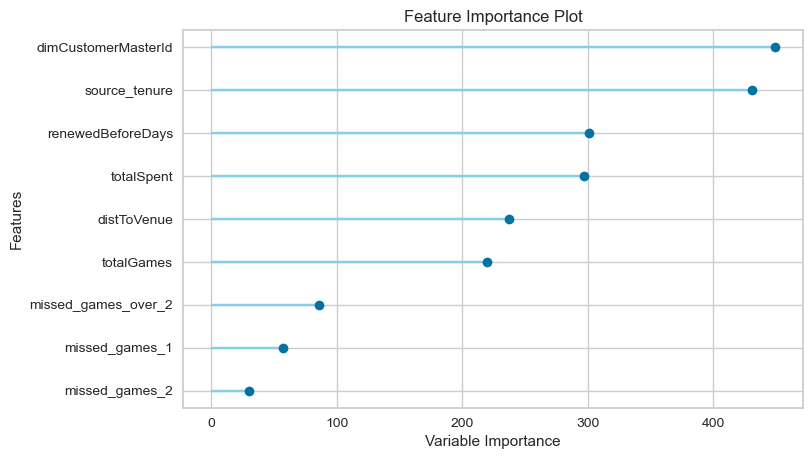

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?